# Raster packages demo: rioxarray (3/3)

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Introduction

Working with raster data is a essential part of geospatial analysis. There are several python packages available for raster processing, and we'll introduce three key tools that build on top of each other...

* GDAL (Geospatial Data Abstraction Library): The low-level foundation that powers most geospatial software. While powerful, it can be complex to use directly.
* rasterio: A more Pythonic interface to GDAL that provides efficient access to raster data using NumPy arrays.
* rioxarray: Higher-level package that combines the power of rasterio with xarray's labeled dimensions and advanced capabilities for handling multi-dimensional data. 

Each package plays an important role in the python geospatial ecosystem, so we'll briefly introduce the tools one at a time to practice some fundamentals and gain some raster intuition. 

*The lower level GDAL and rasterio are very well-supported, and there are indeed use cases for when you might prefer interacting with these lower level tools. Ultimately, we'll focus on rioxarray for the rest of the quarter due to its intuitive handling of multi-dimensional data (e.g. raster time series) and dask integration for scalability.*

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import rioxarray as rxr
import xarray as xr
import pyproj

In [2]:
imgdir = f'{Path.home()}/gda_demo_data/LS8_data'

#Pre-identified cloud-free Image IDs used for the lab
august_id = 'LC08_L2SP_046027_20180818_20200831_02_T1' # August 2018
december_id = 'LC08_L2SP_046027_20181224_20200829_02_T1' # # December 2018

# B2 is the blue band
blue_august_fn = os.path.join(imgdir, august_id+'_SR_B2.TIF')
blue_december_fn = os.path.join(imgdir, december_id+'_SR_B2.TIF')

# define a filename for the reprojected image
blue_august_4326_fn = os.path.join(imgdir, august_id+'_SR_B2_4326.TIF')

print(blue_august_fn)

/home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_SR_B2.TIF


## rioxarray
Use the rioxarray [open_rasterio](https://corteva.github.io/rioxarray/html/rioxarray.html) function.

In [3]:
blue_august_da = rxr.open_rasterio(blue_august_fn) # notice the dimensions and the datatype
blue_august_da

<xarray.DataArray (band: 1, y: 7891, x: 7771)> Size: 123MB
[61320961 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 62kB 4.737e+05 4.737e+05 ... 7.068e+05 7.068e+05
  * y            (y) float64 63kB 5.374e+06 5.374e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

* This is an [xarray](https://docs.xarray.dev/en/latest/getting-started-guide/quick-overview.html) DataArray. The DataArray object contains our raster as a numpy array, but also contains the geographic coordinates and metadata. 

In [4]:
# what does masked=True do? What does squeeze() do?
blue_august_da = rxr.open_rasterio(blue_august_fn,masked=True).squeeze() 
blue_august_da

<xarray.DataArray (y: 7891, x: 7771)> Size: 245MB
[61320961 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 62kB 4.737e+05 4.737e+05 ... 7.068e+05 7.068e+05
  * y            (y) float64 63kB 5.374e+06 5.374e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
# what does overview_level=4 do? how many overview levels are there for this image? how could you find out?
blue_august_da = rxr.open_rasterio(blue_august_fn,masked=True,overview_level=4).squeeze() 
blue_august_da

<xarray.DataArray (y: 247, x: 243)> Size: 240kB
[60021 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB 4.742e+05 4.751e+05 ... 7.054e+05 7.063e+05
  * y            (y) float64 2kB 5.373e+06 5.372e+06 ... 5.138e+06 5.137e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
blue_august_da = rxr.open_rasterio(blue_august_fn,masked=True).squeeze() 
blue_august_da

<xarray.DataArray (y: 7891, x: 7771)> Size: 245MB
[61320961 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 62kB 4.737e+05 4.737e+05 ... 7.068e+05 7.068e+05
  * y            (y) float64 63kB 5.374e+06 5.374e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
blue_august_da.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

In [8]:
blue_august_da.rio.nodata

nan

In [9]:
blue_august_da.rio.encoded_nodata # what's the difference?

0.0

In [10]:
#These are the standard scale and offset values
#SR 0.0000275 + -0.2
sr_scale = 0.0000275
sr_offset = -0.2
#ST 0.00341802 + 149.0
st_scale = 0.00341802
st_offset = 149.0

In [11]:
blue_august_da = blue_august_da * sr_scale + sr_offset
blue_august_da

<xarray.DataArray (y: 7891, x: 7771)> Size: 245MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 62kB 4.737e+05 4.737e+05 ... 7.068e+05 7.068e+05
  * y            (y) float64 63kB 5.374e+06 5.374e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 8B 0

In [12]:
blue_august_da.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

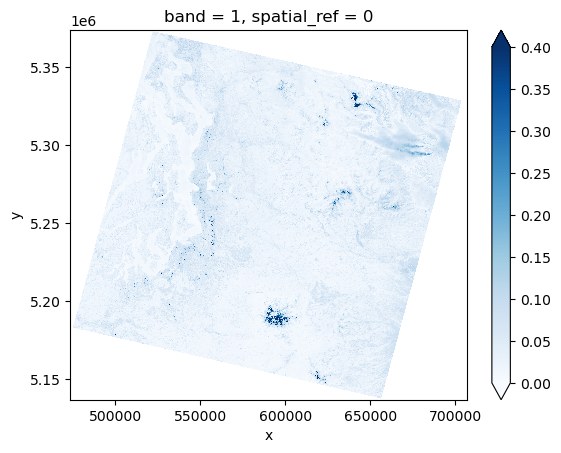

In [13]:
blue_august_da.plot.imshow(cmap='Blues', vmin=0, vmax=0.4)

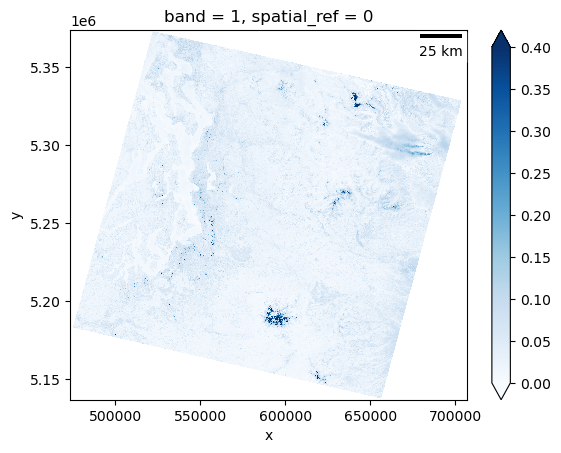

In [14]:
# try adding a scalebar
f,ax=plt.subplots()
blue_august_da.plot.imshow(ax=ax,cmap='Blues', vmin=0, vmax=0.4)
ax.add_artist(ScaleBar(1))

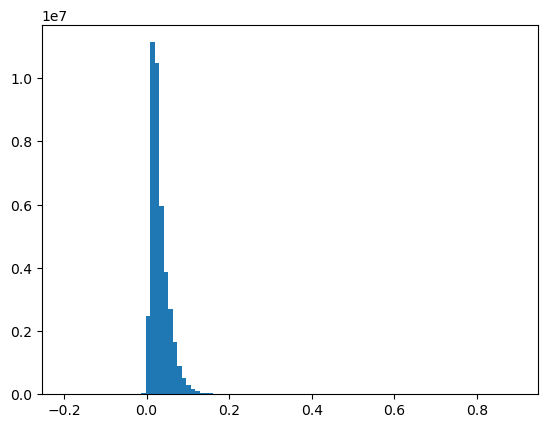

In [15]:
f,ax=plt.subplots()
ax.hist(blue_august_da.values.ravel(),bins=100);

### Sample some points in the raster

In [16]:
lumen_field_proj_point = (550256, 5271504)
husky_stadium_pixel_point = (2623,3198)
lake_washington_latlon_point = (-122.25, 47.6)

In [17]:
transform_4326_point_to_raster_crs = pyproj.Transformer.from_crs("EPSG:4326",blue_august_da.rio.crs,always_xy=True)
parking_lot_latlon_point = transform_4326_point_to_raster_crs.transform(lake_washington_latlon_point[0],lake_washington_latlon_point[1])

In [18]:
lumen_field_value = float(blue_august_da.sel(x=lumen_field_proj_point[0],y=lumen_field_proj_point[1],method='nearest'))
husky_stadium_value = float(blue_august_da.isel(x=husky_stadium_pixel_point[0],y=husky_stadium_pixel_point[1]))
lake_washington_value = float(blue_august_da.sel(x=parking_lot_latlon_point[0],y=parking_lot_latlon_point[1],method='nearest'))

In [19]:
print(f"Lumen Field: {lumen_field_value}")
print(f"Husky Stadium: {husky_stadium_value}")
print(f"Lake Washington: {lake_washington_value}")

Lumen Field: 0.08088500797748566
Husky Stadium: 0.11058498919010162
Lake Washington: 0.0016299933195114136


### Try reprojecting
Pretty easy!

In [20]:
# reproject
blue_august_da.rio.reproject('EPSG:4326').rio.to_raster(blue_august_4326_fn)

### Make an RGB image

In [21]:
#Red
r_fn = os.path.join(imgdir, august_id+'_SR_B4.TIF')
#Green
g_fn = os.path.join(imgdir, august_id+'_SR_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, august_id+'_SR_B2.TIF')

In [22]:
r_da = rxr.open_rasterio(r_fn,masked=True).squeeze()*sr_scale + sr_offset
g_da = rxr.open_rasterio(g_fn,masked=True).squeeze()*sr_scale + sr_offset
b_da = rxr.open_rasterio(b_fn,masked=True).squeeze()*sr_scale + sr_offset

rgb_da = xr.concat([r_da,g_da,b_da],dim='band')
rgb_da

<xarray.DataArray (band: 3, y: 7891, x: 7771)> Size: 736MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 24B 1 1 1
  * x            (x) float64 62kB 4.737e+05 4.737e+05 ... 7.068e+05 7.068e+05
  * y            (y) float64 63kB 5.374e+06 5.374e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 8B 0

In [23]:
# let's select a window based on geographic coordinates Window bounds:  (581685.0, 5174895.0, 612405.0, 5205615.0)
rgb_subset_da = rgb_da.sel(x=slice(581685.0, 612405.0), y=slice(5205615.0, 5174895.0))
rgb_subset_da

<xarray.DataArray (band: 3, y: 1024, x: 1024)> Size: 13MB
array([[[0.020495  , 0.021705  , 0.0201925 , ..., 0.01466499,
         0.01210749, 0.00966001],
        [0.0198625 , 0.01933999, 0.01744249, ..., 0.0189275 ,
         0.0096875 , 0.00933   ],
        [0.01681   , 0.01593   , 0.0150225 , ..., 0.01727749,
         0.0115025 , 0.01142   ],
        ...,
        [0.012135  , 0.01031999, 0.0114475 , ..., 0.01263   ,
         0.012575  , 0.01309749],
        [0.011585  , 0.01199751, 0.01252   , ..., 0.0112    ,
         0.01293249, 0.01265749],
        [0.012245  , 0.01232749, 0.0112275 , ..., 0.01504999,
         0.0146925 , 0.0137575 ]],

       [[0.037435  , 0.03922249, 0.0376275 , ..., 0.02602249,
         0.02329999, 0.0221725 ],
        [0.03515249, 0.03427249, 0.0319075 , ..., 0.02731501,
         0.0232725 , 0.024675  ],
        [0.031385  , 0.0281675 , 0.02769999, ..., 0.0280575 ,
         0.0268475 , 0.02791999],
...
        [0.02539   , 0.022695  , 0.0248675 , ..., 0.0283875 ,
         0.0282225 , 0.02959751],
        [0.0244    , 0.02539   , 0.02802999, ..., 0.02627   ,
         0.02858   , 0.02775499],
        [0.02412499, 0.02607749, 0.02462   , ..., 0.030285  ,
         0.03058749, 0.0299    ]],

       [[0.01851501, 0.0185975 , 0.016425  , ..., 0.01285   ,
         0.01131   , 0.01031999],
        [0.0182125 , 0.0160675 , 0.01477499, ..., 0.01628751,
         0.008395  , 0.0095225 ],
        [0.015985  , 0.01351   , 0.01254749, ..., 0.01532499,
         0.00971501, 0.0107325 ],
        ...,
        [0.00801   , 0.00713   , 0.007515  , ..., 0.00922   ,
         0.0092475 , 0.009385  ],
        [0.00746   , 0.00831249, 0.008505  , ..., 0.008725  ,
         0.009385  , 0.0095775 ],
        [0.00842249, 0.00834   , 0.007625  , ..., 0.01064999,
         0.01070499, 0.01070499]]], dtype=float32)
Coordinates:
  * band         (band) int64 24B 1 1 1
  * x            (x) float64 8kB 5.817e+05 5.817e+05 ... 6.124e+05 6.124e+05
  * y            (y) float64 8kB 5.206e+06 5.206e+06 ... 5.175e+06 5.175e+06
    spatial_ref  int64 8B 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0738025..1.0].


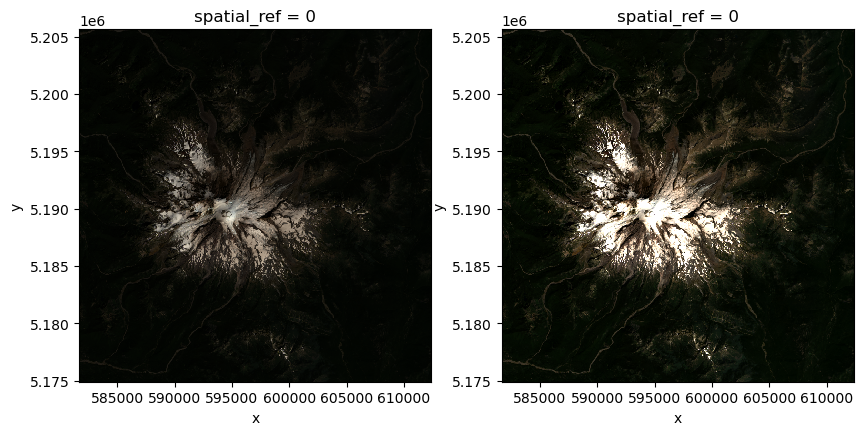

In [24]:
f,axs=plt.subplots(1,2,figsize=(10,10))
rgb_subset_da.plot.imshow(ax=axs[0],rgb='band')
axs[0].set_aspect('equal')

rgb_subset_da.plot.imshow(ax=axs[1],rgb='band',robust=True)
axs[1].set_aspect('equal')